# BERT - Baseline Notebook

This notebook contains fine-tuning a BERT model for music genre classification using song lyrics, optionally adding metadata.

It includes:
- Label encoding of genres

- Metadata normalization

- Lyrics tokenization

- Dataset and DataLoader setup (`LyricsWithMetadataDataset` and `model_setup`)

- A model architecture combining DistilBERT embeddings with metadata features (`BERTWithMetadata`)

- The models are trained and evaluated using functions from `train_eval_utils.py`

The best model in the training is stored to `run_results/models/bert`

The restults are stored to `run_results/results/bert`


<br>
The code is inspired from:

- [Main inspiration: Lecture code - BERT implementation](https://colab.research.google.com/drive/1yWMwSUNhuoy-85KzR1th5e4aN8lR-UaY?usp=sharing)

- [BERT - model documentation](https://huggingface.co/docs/transformers/model_doc/bert)

- [Using pre-trained BERT with PyTorch](https://neptune.ai/blog/how-to-code-bert-using-pytorch-tutorial)

- [ChatGPT](https://chatgpt.com/)



Training was conducted on Google Colab

In [22]:
try:
    # Comment out if not using colab
    from google.colab import drive
    drive.mount('/content/drive')

    %cd "/content/drive/Othercomputers/Min MacBook Pro/semester_project_info371"
except:
    print("Not using Google Colab")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Othercomputers/Min MacBook Pro/semester_project_info371


In [23]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

#Importing local functions
from train_eval_utils import train_model, evaluate_model, save_test_results

In [24]:
train_df = pd.read_csv("music_dataset_split/Train/training_data.csv")
val_df = pd.read_csv("music_dataset_split/Val/validation_data.csv")
test_df = pd.read_csv("music_dataset_split/Test/test_data.csv")

In [25]:
train_df.head(5)

,id,release_date,genre,lyrics,danceability
0,27780,2012,hip hop,wanna sound wanna sound feel marvelous right d...,0.541861
1,25749,1997,rock,time time time time time honk horn fuck fuck f...,0.753060
2,22028,1997,reggae,play game long start believe doubt try convinc...,0.710820
3,20445,2013,jazz,stop love mind live memories lonesome time sto...,0.596014
4,4885,2001,pop,people wanna kick nerd grow suburbs go wrong s...,0.463880


In [26]:
train_df['genre'].value_counts()

,count
genre,
pop,4870
country,3780
blues,3152
rock,2766
jazz,2582
reggae,1730
hip hop,630


## BERT - BASELINE

**Label encode genres**

In [27]:
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['genre'])
val_df['label'] = label_encoder.transform(val_df['genre'])
test_df['label'] = label_encoder.transform(test_df['genre'])

**Normalize metadata based on training set only**

In [28]:
scaler = MinMaxScaler()
scaler.fit(train_df[['release_date', 'danceability']])

train_df[['release_date', 'danceability']] = scaler.transform(train_df[['release_date', 'danceability']])
val_df[['release_date', 'danceability']] = scaler.transform(val_df[['release_date', 'danceability']])
test_df[['release_date', 'danceability']] = scaler.transform(test_df[['release_date', 'danceability']])

**Tokenization**

In [29]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [30]:
def tokenize_lyrics(df):
    return tokenizer(list(df['lyrics']), truncation=True, padding='max_length', max_length=256)


In [31]:
class LyricsWithMetadataDataset(Dataset):
    def __init__(self, df, encodings, use_release=True, use_dance=True):
        self.encodings = encodings
        self.labels = df['label'].tolist()

        selected_columns = []
        if use_release:
            selected_columns.append('release_date')
        if use_dance:
            selected_columns.append('danceability')

        self.metadata = df[selected_columns].values.astype('float32') if selected_columns else None
        self.use_metadata = bool(selected_columns)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.use_metadata:
            item['metadata'] = torch.tensor(self.metadata[idx])
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [43]:
class BERTWithMetadata(nn.Module):
    def __init__(self, metadata_input_dim, num_labels):
        super().__init__()
        self.use_metadata = metadata_input_dim > 0
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)

        if self.use_metadata:
            self.metadata_dense = nn.Linear(metadata_input_dim, 768)
            self.classifier = nn.Linear(768 + 768, num_labels)
            print(f"[Model Setup] Metadata ENABLED")
        else:
            self.classifier = nn.Linear(768, num_labels)
            print("[Model Setup] Metadata DISABLED")

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, input_ids, attention_mask, metadata=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.last_hidden_state[:, 0])

        if self.use_metadata and metadata is not None:
            metadata_embed = self.dropout(self.metadata_dense(metadata))
            combined = torch.cat((pooled_output, metadata_embed), dim=1)
            pooled_output = combined

        logits = self.classifier(pooled_output)
        return logits

In [33]:
num_labels = len(label_encoder.classes_)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
def model_setup(use_release=True, use_dance=True):
    train_encodings = tokenize_lyrics(train_df)
    val_encodings = tokenize_lyrics(val_df)

    train_dataset = LyricsWithMetadataDataset(train_df, train_encodings, use_release=use_release, use_dance=use_dance)
    val_dataset = LyricsWithMetadataDataset(val_df, val_encodings, use_release=use_release, use_dance=use_dance)


    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    if use_release and use_dance:
        metadata_input_dim = 2
    elif use_release or use_dance:
        metadata_input_dim = 1
    else:
        metadata_input_dim = 0

    model = BERTWithMetadata(metadata_input_dim, num_labels=num_labels).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=2e-5)
    loss_fn = nn.CrossEntropyLoss()

    return model, optimizer, loss_fn, train_loader, val_loader

## Training and evaluation of our model

**Test set setup**

In [35]:
test_encodings = tokenize_lyrics(test_df)

No metadata - testset

In [36]:
no_md_test_dataset = LyricsWithMetadataDataset(test_df, test_encodings, use_release=False, use_dance=False)
no_md_test_loader = DataLoader(no_md_test_dataset, batch_size=16)

Year as metadata setup

In [37]:
year_test_dataset = LyricsWithMetadataDataset(test_df, test_encodings, use_release=True, use_dance=False)
year_test_loader = DataLoader(no_md_test_dataset, batch_size=16)

Dancability as metadata setup

In [38]:
dance_test_dataset = LyricsWithMetadataDataset(test_df, test_encodings, use_release=False, use_dance=True)
dance_test_loader = DataLoader(dance_test_dataset, batch_size=16)

Year and dancability as metadata setup

In [39]:
year_dance_test_dataset = LyricsWithMetadataDataset(test_df, test_encodings, use_release=True, use_dance=True)
year_dance_test_loader = DataLoader(year_dance_test_dataset, batch_size=16)

## **Run training and testing**

In [40]:
no_md_model = train_model(
    use_release=False,
    use_dance=False,
    epochs=3,
    description="bert/no_metadata_bert",
    model_setup_encoder=model_setup
)


------ Metadata Usage Configuration ------
Using release_year: False
Using danceability: False
[Model Setup] Metadata DISABLED


Epoch 1 Training: 100%|██████████| 1220/1220 [06:16<00:00,  3.24it/s]



Epoch 1, Train Loss: 1.6018, Train Accuracy: 0.3615

validation score: Val Loss: 1.51, Val Accuracy: 0.41
[Best Model Saved] Epoch 1 with val loss: 1.5129


Epoch 2 Training: 100%|██████████| 1220/1220 [06:19<00:00,  3.22it/s]



Epoch 2, Train Loss: 1.3932, Train Accuracy: 0.4725

validation score: Val Loss: 1.46, Val Accuracy: 0.44
[Best Model Saved] Epoch 2 with val loss: 1.4635


Epoch 3 Training: 100%|██████████| 1220/1220 [06:19<00:00,  3.22it/s]



Epoch 3, Train Loss: 1.1623, Train Accuracy: 0.5719

validation score: Val Loss: 1.53, Val Accuracy: 0.43

[Model Restored] Loaded best model from epoch 2 with val loss: 1.4635


[Evaluation] Model loaded from file 'no_metadata_bert' (epoch 2, val_loss: 1.4635)
Test - No metadata - Baseline BERT Accuracy: 0.44

Classification Report:
              precision    recall  f1-score   support

       blues       0.37      0.32      0.34       676
     country       0.51      0.55      0.53       810
     hip hop       0.77      0.53      0.63       135
        jazz       0.51      0.19      0.28       553
         pop       0.37      0.64      0.46      1044
      reggae       0.61      0.36      0.46       371
        rock       0.49      0.31      0.38       592

    accuracy                           0.44      4181
   macro avg       0.52      0.41      0.44      4181
weighted avg       0.47      0.44      0.42      4181



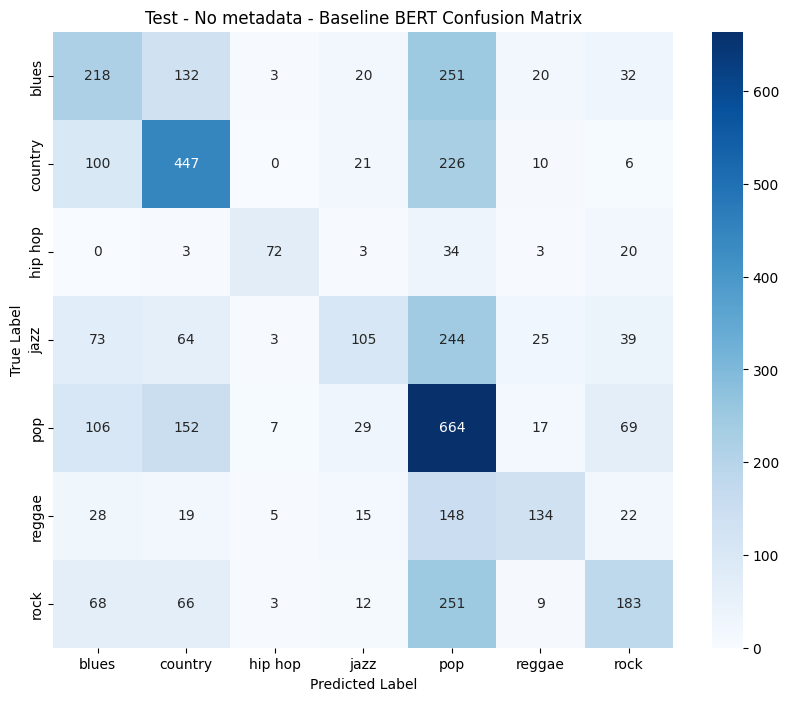

[Saved] Test results saved to: run_results/results/distilbert/bert/results_no_metadata_b


In [41]:
evaluate_model(
    no_md_model,
    no_md_test_loader,
    label="Test - No metadata - Baseline BERT",
    folder = "bert/",
    description = "no_metadata_bert",
    file_name="results_no_metadata_b",
    label_encoder=label_encoder
)


**Run training - Lyrics + release year**

In [44]:
year_model = train_model(
    use_release=True,
    use_dance=False,
    epochs=3,
    description="bert/year_bert",
    model_setup_encoder=model_setup
)


------ Metadata Usage Configuration ------
Using release_year: True
Using danceability: False
[Model Setup] Metadata ENABLED


Epoch 1 Training: 100%|██████████| 1220/1220 [06:16<00:00,  3.24it/s]



Epoch 1, Train Loss: 1.5923, Train Accuracy: 0.3643

validation score: Val Loss: 1.44, Val Accuracy: 0.44
[Best Model Saved] Epoch 1 with val loss: 1.4440


Epoch 2 Training: 100%|██████████| 1220/1220 [06:19<00:00,  3.21it/s]



Epoch 2, Train Loss: 1.3710, Train Accuracy: 0.4807

validation score: Val Loss: 1.45, Val Accuracy: 0.45


Epoch 3 Training: 100%|██████████| 1220/1220 [06:19<00:00,  3.21it/s]



Epoch 3, Train Loss: 1.1287, Train Accuracy: 0.5836

validation score: Val Loss: 1.56, Val Accuracy: 0.44

[Model Restored] Loaded best model from epoch 1 with val loss: 1.4440


[Evaluation] Model loaded from file 'year_bert' (epoch 1, val_loss: 1.4440)
Test - with release year Accuracy: 0.43

Classification Report:
              precision    recall  f1-score   support

       blues       0.39      0.26      0.32       676
     country       0.50      0.57      0.53       810
     hip hop       0.97      0.53      0.69       135
        jazz       0.47      0.29      0.35       553
         pop       0.35      0.62      0.45      1044
      reggae       0.66      0.33      0.44       371
        rock       0.48      0.30      0.37       592

    accuracy                           0.43      4181
   macro avg       0.55      0.41      0.45      4181
weighted avg       0.47      0.43      0.43      4181



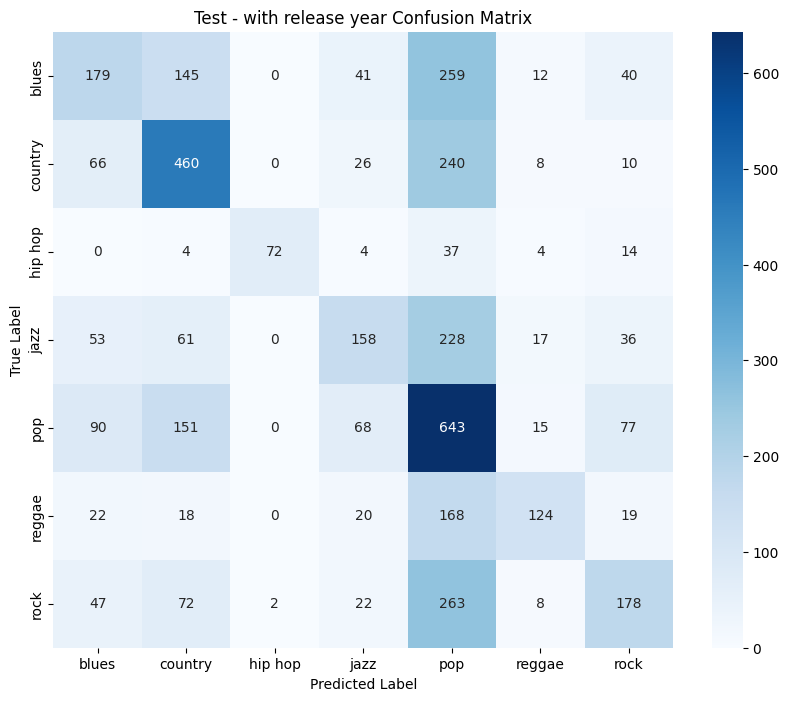

[Saved] Test results saved to: run_results/results/distilbert/bert/results_year_bert


In [45]:
evaluate_model(
    year_model,
    year_test_loader,
    label="Test - with release year - Baseline BERT",
    folder = "bert/",
    description = "year_bert",
    file_name="results_year_bert",
    label_encoder=label_encoder
)

In [46]:
dance_model = train_model(
    use_release=False,
    use_dance=True,
    epochs=3,
    description="bert/dance_bert",
    model_setup_encoder=model_setup
)


------ Metadata Usage Configuration ------
Using release_year: False
Using danceability: True
[Model Setup] Metadata ENABLED


Epoch 1 Training: 100%|██████████| 1220/1220 [06:20<00:00,  3.21it/s]



Epoch 1, Train Loss: 1.5883, Train Accuracy: 0.3625

validation score: Val Loss: 1.45, Val Accuracy: 0.43
[Best Model Saved] Epoch 1 with val loss: 1.4502


Epoch 2 Training: 100%|██████████| 1220/1220 [06:20<00:00,  3.21it/s]



Epoch 2, Train Loss: 1.3573, Train Accuracy: 0.4773

validation score: Val Loss: 1.48, Val Accuracy: 0.43


Epoch 3 Training: 100%|██████████| 1220/1220 [06:19<00:00,  3.21it/s]



Epoch 3, Train Loss: 1.1246, Train Accuracy: 0.5819

validation score: Val Loss: 1.52, Val Accuracy: 0.43

[Model Restored] Loaded best model from epoch 1 with val loss: 1.4502


[Evaluation] Model loaded from file 'dance_bert' (epoch 1, val_loss: 1.4502)
Test - with danceability Accuracy: 0.43

Classification Report:
              precision    recall  f1-score   support

       blues       0.42      0.21      0.28       676
     country       0.44      0.71      0.55       810
     hip hop       0.90      0.57      0.70       135
        jazz       0.54      0.18      0.27       553
         pop       0.35      0.58      0.43      1044
      reggae       0.62      0.38      0.47       371
        rock       0.53      0.27      0.36       592

    accuracy                           0.43      4181
   macro avg       0.54      0.41      0.44      4181
weighted avg       0.47      0.43      0.41      4181



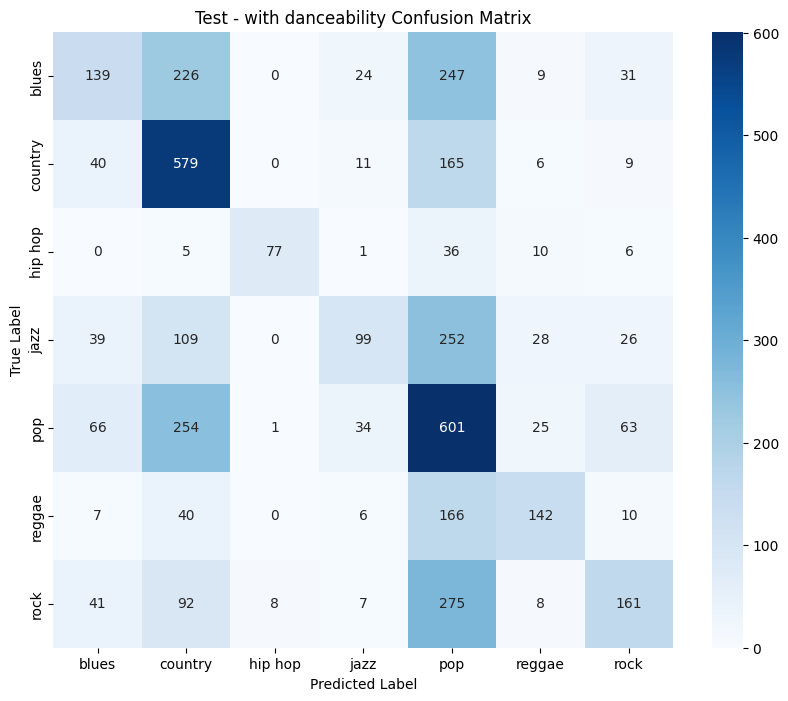

[Saved] Test results saved to: run_results/results/distilbert/bert/results_dance_bert


In [47]:
evaluate_model(
    dance_model,
    dance_test_loader,
    label="Test - with danceability - Baseline BERT",
    folder = "bert/",
    description = "dance_bert",
    file_name="results_dance_bert",
    label_encoder=label_encoder
)

In [50]:
both_model = train_model(
    use_release=True,
    use_dance=True,
    epochs=3,
    description="bert/both_md_bert",
    model_setup_encoder=model_setup
)


------ Metadata Usage Configuration ------
Using release_year: True
Using danceability: True
[Model Setup] Metadata ENABLED


Epoch 1 Training: 100%|██████████| 1220/1220 [06:19<00:00,  3.22it/s]



Epoch 1, Train Loss: 1.5790, Train Accuracy: 0.3716

validation score: Val Loss: 1.47, Val Accuracy: 0.42
[Best Model Saved] Epoch 1 with val loss: 1.4721


Epoch 2 Training: 100%|██████████| 1220/1220 [06:19<00:00,  3.21it/s]



Epoch 2, Train Loss: 1.3762, Train Accuracy: 0.4718

validation score: Val Loss: 1.43, Val Accuracy: 0.45
[Best Model Saved] Epoch 2 with val loss: 1.4258


Epoch 3 Training: 100%|██████████| 1220/1220 [06:20<00:00,  3.21it/s]



Epoch 3, Train Loss: 1.1643, Train Accuracy: 0.5676

validation score: Val Loss: 1.48, Val Accuracy: 0.44

[Model Restored] Loaded best model from epoch 2 with val loss: 1.4258


[Evaluation] Model loaded from file 'both_md_bert' (epoch 2, val_loss: 1.4258)
Test - with year and danceability - Baseline BERT Accuracy: 0.46

Classification Report:
              precision    recall  f1-score   support

       blues       0.33      0.47      0.39       676
     country       0.49      0.66      0.57       810
     hip hop       0.92      0.53      0.68       135
        jazz       0.42      0.38      0.40       553
         pop       0.45      0.40      0.42      1044
      reggae       0.57      0.52      0.54       371
        rock       0.57      0.27      0.37       592

    accuracy                           0.46      4181
   macro avg       0.54      0.46      0.48      4181
weighted avg       0.48      0.46      0.45      4181



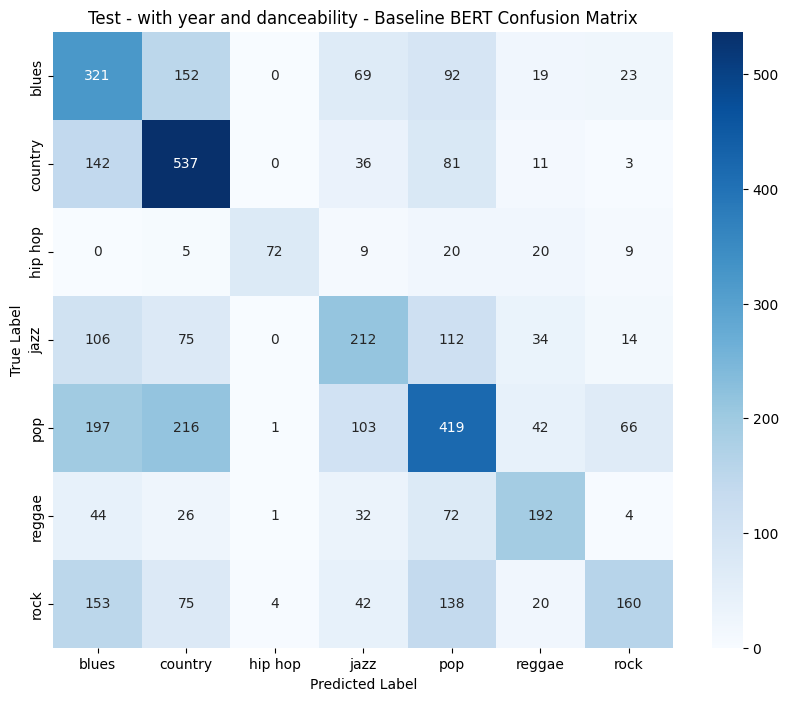

[Saved] Test results saved to: run_results/results/distilbert/bert/results_both_md_bert


In [51]:
evaluate_model(
    both_model,
    year_dance_test_loader,
    label="Test - with year and danceability - Baseline BERT",
    folder = "bert/",
    description = "both_md_bert",
    file_name="results_both_md_bert",
    label_encoder=label_encoder
)